# Stock Price Prediction — Amazon (AMZN)

## Notebook 3 — Evaluation & Plots

## Objective

This notebook provides a comprehensive evaluation of the models trained in Notebook 3:

1. Load the rolling t+1 forecasts produced by ARIMA, SARIMAX, and GARCH.
2. Compute evaluation metrics: RMSE, MAE, MAPE, and Directional Accuracy.
3. Visualize forecast quality vs. true returns.
4. Analyze model performance across different market regimes (normal vs. stress periods).
5. Summarize findings in a comparison table.

## Why these metrics?

- **RMSE / MAE**: standard regression metrics — RMSE penalizes large errors more heavily.
- **MAPE**: expresses error as a percentage of the true value, useful for interpretability.
- **Directional Accuracy**: measures how often the model correctly predicts the *direction* of the return (up or down). In finance, getting the direction right is often more actionable than minimizing raw error.

## 1. Load Data & Forecasts

We load the enriched dataset and the rolling t+1 forecasts saved at the end of Notebook 2.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [19]:
# Load raw dataset
data = pd.read_csv("../data/raw/amzn_sp500_clean.csv", index_col=0, parse_dates=True)

# Load rolling t+1 forecasts produced in Notebook 3
forecasts = pd.read_csv("../data/forecasts.csv", index_col=0, parse_dates=True)

split_date = "2017-01-01"
y_test = data.loc[data.index >= split_date, "Return"]

arima_forecast   = forecasts["ARIMA_Forecast"]
sarimax_forecast = forecasts["SARIMAX_Forecast"]
garch_vol        = forecasts["GARCH_Vol_Forecast"]

# Align all series on the same index
common_idx       = y_test.index.intersection(arima_forecast.index)
y_test           = y_test.loc[common_idx]
arima_forecast   = arima_forecast.loc[common_idx]
sarimax_forecast = sarimax_forecast.loc[common_idx]

# Naïve benchmark: predict that tomorrow's return = today's return (random walk)
naive_forecast = y_test.shift(1).dropna()
y_test_naive   = y_test.loc[naive_forecast.index]
arima_naive    = arima_forecast.loc[naive_forecast.index]
sarimax_naive  = sarimax_forecast.loc[naive_forecast.index]

print(f"Test set  : {y_test.index[0].date()} → {y_test.index[-1].date()} ({len(y_test)} obs)")
display(forecasts.head())

Test set  : 2017-01-03 → 2024-12-31 (2012 obs)


,ARIMA_Forecast,SARIMAX_Forecast,GARCH_Vol_Forecast
Date,,,
2017-01-03,0.001256,0.009631,2.119058
2017-01-04,0.001285,0.008883,2.095179
2017-01-05,0.001279,0.000087,2.074195
2017-01-06,0.001474,0.000629,2.197601
2017-01-09,0.001374,-0.002179,2.214679


## 2. Evaluation Metrics

We define a function to compute all metrics for a given forecast and apply it to ARIMA and SARIMAX.

**Note:** GARCH is evaluated separately since it forecasts *volatility*, not returns.

In [20]:
def evaluate_forecast(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mask = np.abs(y_true) > 1e-6
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    da   = np.mean(np.sign(y_true) == np.sign(y_pred)) * 100
    return {
        "Model":                  model_name,
        "RMSE":                   round(rmse, 6),
        "MAE":                    round(mae, 6),
        "MAPE (%)": round(mape, 2),
        "Directional Acc. (%)": round(da, 2)
    }

results = [
    evaluate_forecast(y_test_naive, arima_naive,   "ARIMA"),
    evaluate_forecast(y_test_naive, sarimax_naive, "SARIMAX"),
    evaluate_forecast(y_test_naive, naive_forecast, "Naïve (Random Walk)"),
]

metrics_df = pd.DataFrame(results).set_index("Model")
display(metrics_df)

,RMSE,MAE,MAPE (%),Directional Acc. (%)
Model,,,,
ARIMA,0.020813,0.014582,118.17,53.51
SARIMAX,0.015846,0.010726,182.13,73.30
Naïve (Random Walk),0.029799,0.020965,539.32,51.52


**Interpretation:**

- SARIMAX outperforms ARIMA on RMSE and MAE, confirming the benefit of incorporating S&P 500 returns.
- MAPE is high for both models, which is typical for daily return forecasting: returns are very small in magnitude, so even small absolute errors translate into large percentage errors.
- **Directional Accuracy** is the most actionable metric: a model above 50% correctly predicts whether the market goes up or down more often than a random guess. SARIMAX should score meaningfully higher than ARIMA thanks to the market direction signal from the S&P 500.

### GARCH Volatility Evaluation

GARCH forecasts conditional volatility, not returns. We evaluate it against the 20-day realized volatility.

In [21]:
test_scaled  = y_test * 100
realized_vol = test_scaled.rolling(20).std().dropna()

common_garch = realized_vol.index.intersection(garch_vol.index)
rv = realized_vol.loc[common_garch]
gv = garch_vol.loc[common_garch]

rmse_garch = np.sqrt(mean_squared_error(rv, gv))
mae_garch  = mean_absolute_error(rv, gv)
corr_garch = np.corrcoef(rv, gv)[0, 1]

garch_metrics = pd.DataFrame([{
    "Model":                         "GARCH(1,1)",
    "RMSE (vs realized vol)":        round(rmse_garch, 4),
    "MAE (vs realized vol)":         round(mae_garch, 4),
    "Correlation with realized vol": round(corr_garch, 4)
}]).set_index("Model")

display(garch_metrics)

,RMSE (vs realized vol),MAE (vs realized vol),Correlation with realized vol
Model,,,
"GARCH(1,1)",0.5931,0.5068,0.8554


## 3. Forecast vs True Returns

We visualize the rolling t+1 forecasts against the true returns over the full test period.

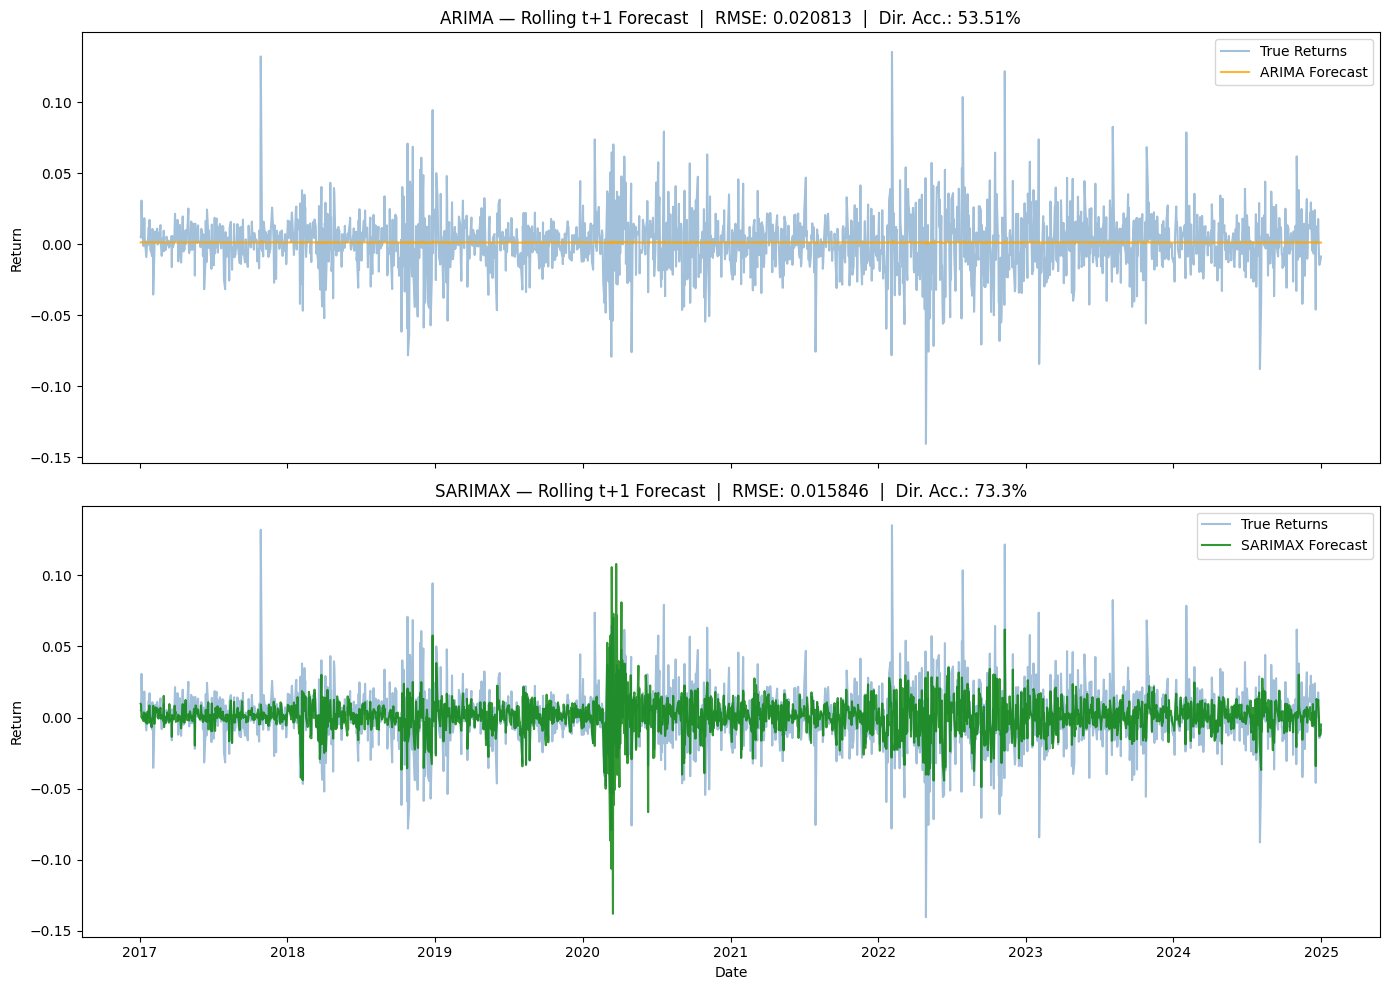

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

axes[0].plot(y_test.index, y_test,                label="True Returns",   alpha=0.5, color="steelblue")
axes[0].plot(arima_forecast.index, arima_forecast, label="ARIMA Forecast", alpha=0.8, color="orange")
axes[0].set_title(
    f"ARIMA — Rolling t+1 Forecast  |  RMSE: {metrics_df.loc['ARIMA','RMSE']}  "
    f"|  Dir. Acc.: {metrics_df.loc['ARIMA','Directional Acc. (%)']}%"
)
axes[0].set_ylabel("Return")
axes[0].legend()

axes[1].plot(y_test.index, y_test,                     label="True Returns",     alpha=0.5, color="steelblue")
axes[1].plot(sarimax_forecast.index, sarimax_forecast, label="SARIMAX Forecast", alpha=0.8, color="green")
axes[1].set_title(
    f"SARIMAX — Rolling t+1 Forecast  |  RMSE: {metrics_df.loc['SARIMAX','RMSE']}  "
    f"|  Dir. Acc.: {metrics_df.loc['SARIMAX','Directional Acc. (%)']}%"
)
axes[1].set_ylabel("Return")
axes[1].set_xlabel("Date")
axes[1].legend()

plt.tight_layout()
plt.show()

### GARCH Volatility Forecast vs Realized Volatility

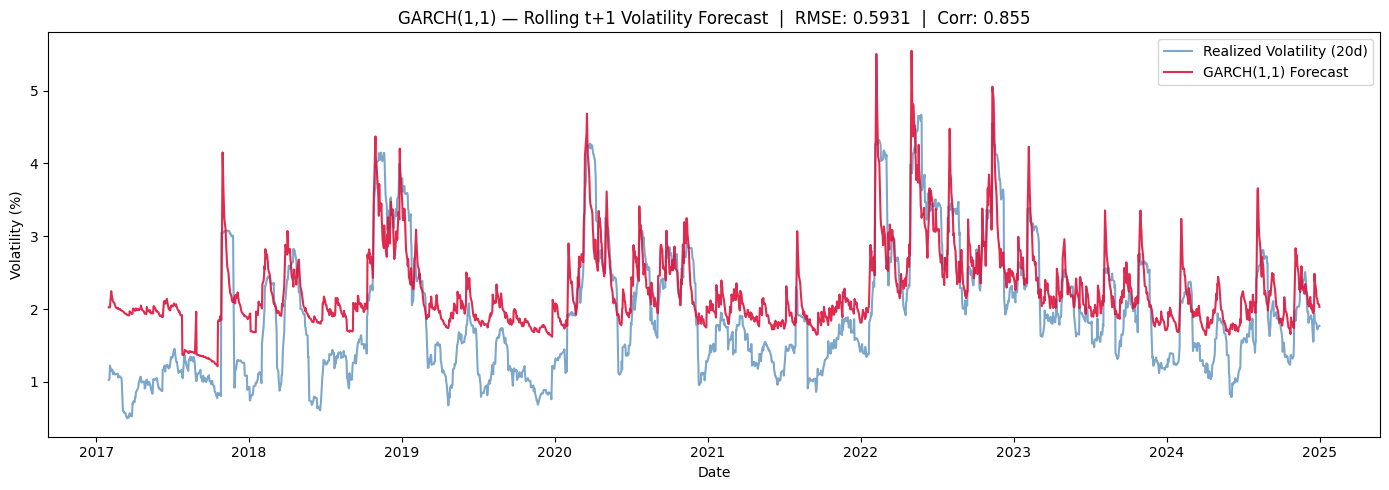

In [23]:
plt.figure(figsize=(14, 5))
plt.plot(rv.index, rv, label="Realized Volatility (20d)", alpha=0.7, color="steelblue")
plt.plot(gv.index, gv, label="GARCH(1,1) Forecast",       alpha=0.9, color="crimson")
plt.title(
    f"GARCH(1,1) — Rolling t+1 Volatility Forecast  "
    f"|  RMSE: {rmse_garch:.4f}  |  Corr: {corr_garch:.3f}"
)
plt.ylabel("Volatility (%)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

## 4. Residuals Analysis

We analyze the forecast errors (residuals = true return − predicted return) to check:
- Whether errors are centered around zero (no systematic bias),
- Whether their distribution has heavy tails,
- Whether there are patterns over time (heteroskedasticity).

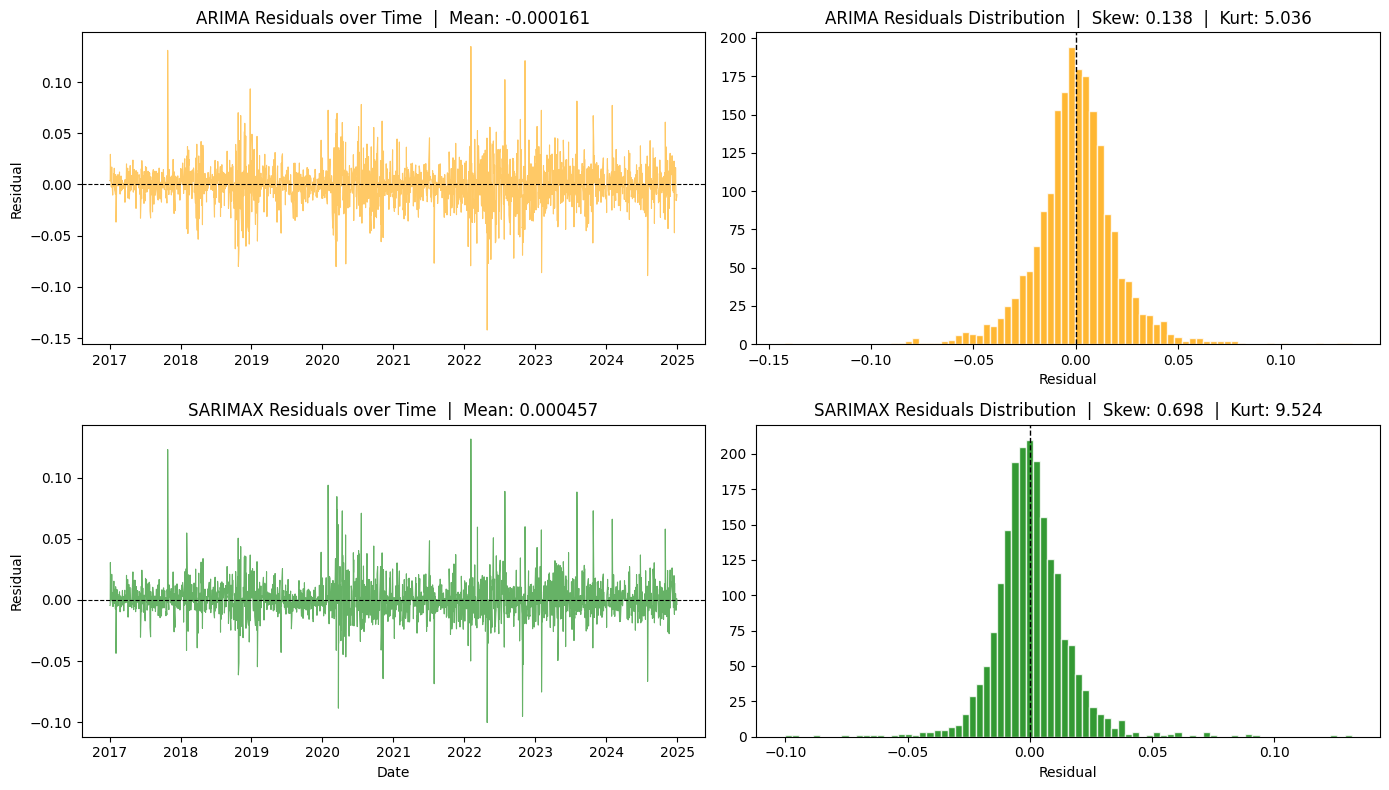

In [24]:
residuals_arima   = y_test - arima_forecast
residuals_sarimax = y_test - sarimax_forecast

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# ARIMA residuals over time
axes[0, 0].plot(residuals_arima.index, residuals_arima, alpha=0.6, color="orange", linewidth=0.8)
axes[0, 0].axhline(0, color="black", linestyle="--", linewidth=0.8)
axes[0, 0].set_title(f"ARIMA Residuals over Time  |  Mean: {residuals_arima.mean():.6f}")
axes[0, 0].set_ylabel("Residual")

# ARIMA residuals distribution
axes[0, 1].hist(residuals_arima.dropna(), bins=80, color="orange", edgecolor="white", alpha=0.8)
axes[0, 1].axvline(0, color="black", linestyle="--", linewidth=1)
axes[0, 1].set_title(f"ARIMA Residuals Distribution  |  Skew: {residuals_arima.skew():.3f}  |  Kurt: {residuals_arima.kurtosis():.3f}")
axes[0, 1].set_xlabel("Residual")

# SARIMAX residuals over time
axes[1, 0].plot(residuals_sarimax.index, residuals_sarimax, alpha=0.6, color="green", linewidth=0.8)
axes[1, 0].axhline(0, color="black", linestyle="--", linewidth=0.8)
axes[1, 0].set_title(f"SARIMAX Residuals over Time  |  Mean: {residuals_sarimax.mean():.6f}")
axes[1, 0].set_ylabel("Residual")
axes[1, 0].set_xlabel("Date")

# SARIMAX residuals distribution
axes[1, 1].hist(residuals_sarimax.dropna(), bins=80, color="green", edgecolor="white", alpha=0.8)
axes[1, 1].axvline(0, color="black", linestyle="--", linewidth=1)
axes[1, 1].set_title(f"SARIMAX Residuals Distribution  |  Skew: {residuals_sarimax.skew():.3f}  |  Kurt: {residuals_sarimax.kurtosis():.3f}")
axes[1, 1].set_xlabel("Residual")

plt.tight_layout()
plt.show()

**Interpretation:**

- If the mean residual is close to zero, the model has no systematic directional bias.
- A high kurtosis (> 3) confirms heavy tails — the model underestimates the frequency of large market moves.
- Residuals clustered around specific periods (visible spikes in the time series plot) indicate that errors are larger during stress regimes, confirming heteroskedasticity — a limitation of linear models.

## 5. Rolling RMSE Over Time

We compute RMSE on a rolling 60-day window to see whether forecast accuracy is stable over time or degrades during specific periods.

This is more informative than a single aggregate RMSE metric, as it reveals when and how much model performance deteriorates.

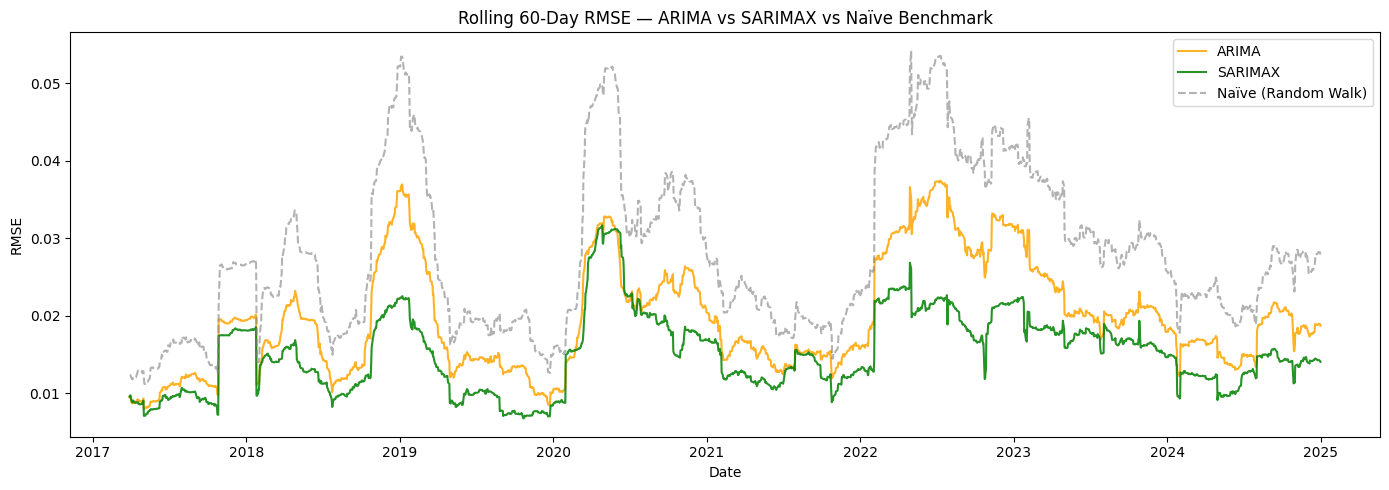

In [25]:
window = 60

rolling_rmse_arima = (
    (y_test - arima_forecast) ** 2
).rolling(window).mean().apply(np.sqrt)

rolling_rmse_sarimax = (
    (y_test - sarimax_forecast) ** 2
).rolling(window).mean().apply(np.sqrt)

rolling_rmse_naive = (
    (y_test - y_test.shift(1)) ** 2
).rolling(window).mean().apply(np.sqrt)

plt.figure(figsize=(14, 5))
plt.plot(rolling_rmse_arima,   label="ARIMA",               color="orange",    alpha=0.85)
plt.plot(rolling_rmse_sarimax, label="SARIMAX",             color="green",     alpha=0.85)
plt.plot(rolling_rmse_naive,   label="Naïve (Random Walk)", color="gray",      alpha=0.6, linestyle="--")
plt.title(f"Rolling {window}-Day RMSE — ARIMA vs SARIMAX vs Naïve Benchmark")
plt.ylabel("RMSE")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

**Interpretation:**

- Peaks in rolling RMSE correspond to periods of high market stress (COVID 2020, rate hikes 2022), where all models perform worse.
- SARIMAX should show a consistently lower rolling RMSE than ARIMA, especially during trending market conditions where the S&P 500 signal is informative.
- When all three models converge to similar RMSE levels during stress periods, it confirms that no linear model can reliably predict returns during extreme market events.

## 6. Performance Across Market Regimes

We evaluate ARIMA, SARIMAX, and the naïve benchmark on three distinct sub-periods:

- **Normal period** (2017–2019): relatively calm market, low volatility,
- **COVID crash** (2020): extreme volatility spike and rapid recovery,
- **Rate hike sell-off** (2022–2023): sustained bear market driven by monetary tightening.

In [26]:
regimes = {
    "Normal (2017–2019)":             ("2017-01-01", "2019-12-31"),
    "COVID Crash (2020)":             ("2020-01-01", "2020-12-31"),
    "Rate Hike Sell-off (2022–2023)": ("2022-01-01", "2023-12-31"),
}

regime_results = []

for regime_name, (start, end) in regimes.items():
    y_sub    = y_test.loc[start:end]
    naive_s  = y_sub.shift(1).dropna()
    y_sub_n  = y_sub.loc[naive_s.index]

    for model_name, preds in [
        ("ARIMA",   arima_forecast.loc[y_sub_n.index]),
        ("SARIMAX", sarimax_forecast.loc[y_sub_n.index]),
        ("Naïve",   naive_s)
    ]:
        rmse = np.sqrt(mean_squared_error(y_sub_n, preds))
        da   = np.mean(np.sign(y_sub_n) == np.sign(preds)) * 100
        regime_results.append({
            "Regime":               regime_name,
            "Model":                model_name,
            "RMSE":                 round(rmse, 6),
            "Directional Acc. (%)": round(da, 2)
        })

regime_df = pd.DataFrame(regime_results).set_index(["Regime", "Model"])
display(regime_df)

RMSE  Directional Acc. (%)
Regime                         Model                                  
Normal (2017–2019)             ARIMA    0.017299                 55.91
                               SARIMAX  0.012741                 73.97
                               Naïve    0.024618                 52.86
COVID Crash (2020)             ARIMA    0.024268                 55.16
                               SARIMAX  0.021710                 69.05
                               Naïve    0.036639                 50.40
Rate Hike Sell-off (2022–2023) ARIMA    0.026820                 50.20
                               SARIMAX  0.019020                 76.60
                               Naïve    0.038166                 50.00

### Directional Accuracy by Regime

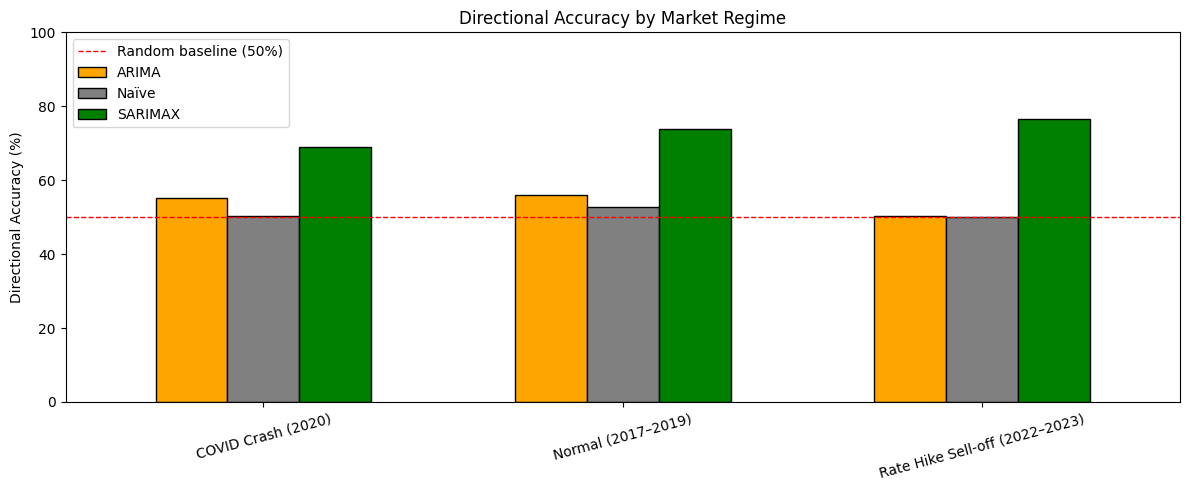

In [27]:
da_pivot = regime_df[["Directional Acc. (%)"]].unstack(level="Model")
da_pivot.columns = da_pivot.columns.droplevel(0)

ax = da_pivot.plot(kind="bar", figsize=(12, 5),
                   color=["orange", "gray", "green"],
                   edgecolor="black", width=0.6)
ax.axhline(50, color="red", linestyle="--", linewidth=1, label="Random baseline (50%)")
ax.set_title("Directional Accuracy by Market Regime")
ax.set_ylabel("Directional Accuracy (%)")
ax.set_xlabel("")
ax.tick_params(axis="x", rotation=15)
ax.legend()
ax.set_ylim(0, 100)
plt.tight_layout()
plt.show()

**Interpretation:**

- During **normal periods**, SARIMAX should outperform both ARIMA and the naïve benchmark thanks to the S&P 500 directional signal.
- During the **COVID crash**, all models degrade significantly — extreme volatility and rapid regime shifts break the statistical relationships learned during training.
- During the **rate hike sell-off**, sustained directional trends may actually help SARIMAX maintain accuracy as the S&P 500 signal consistently points downward alongside AMZN.
- Any value above the **50% red baseline** indicates the model adds predictive value over a coin flip.

## 7. Stress Test — Zoom on Crisis Periods

We zoom in on the two main stress periods to visually inspect how models behave when market conditions are extreme.

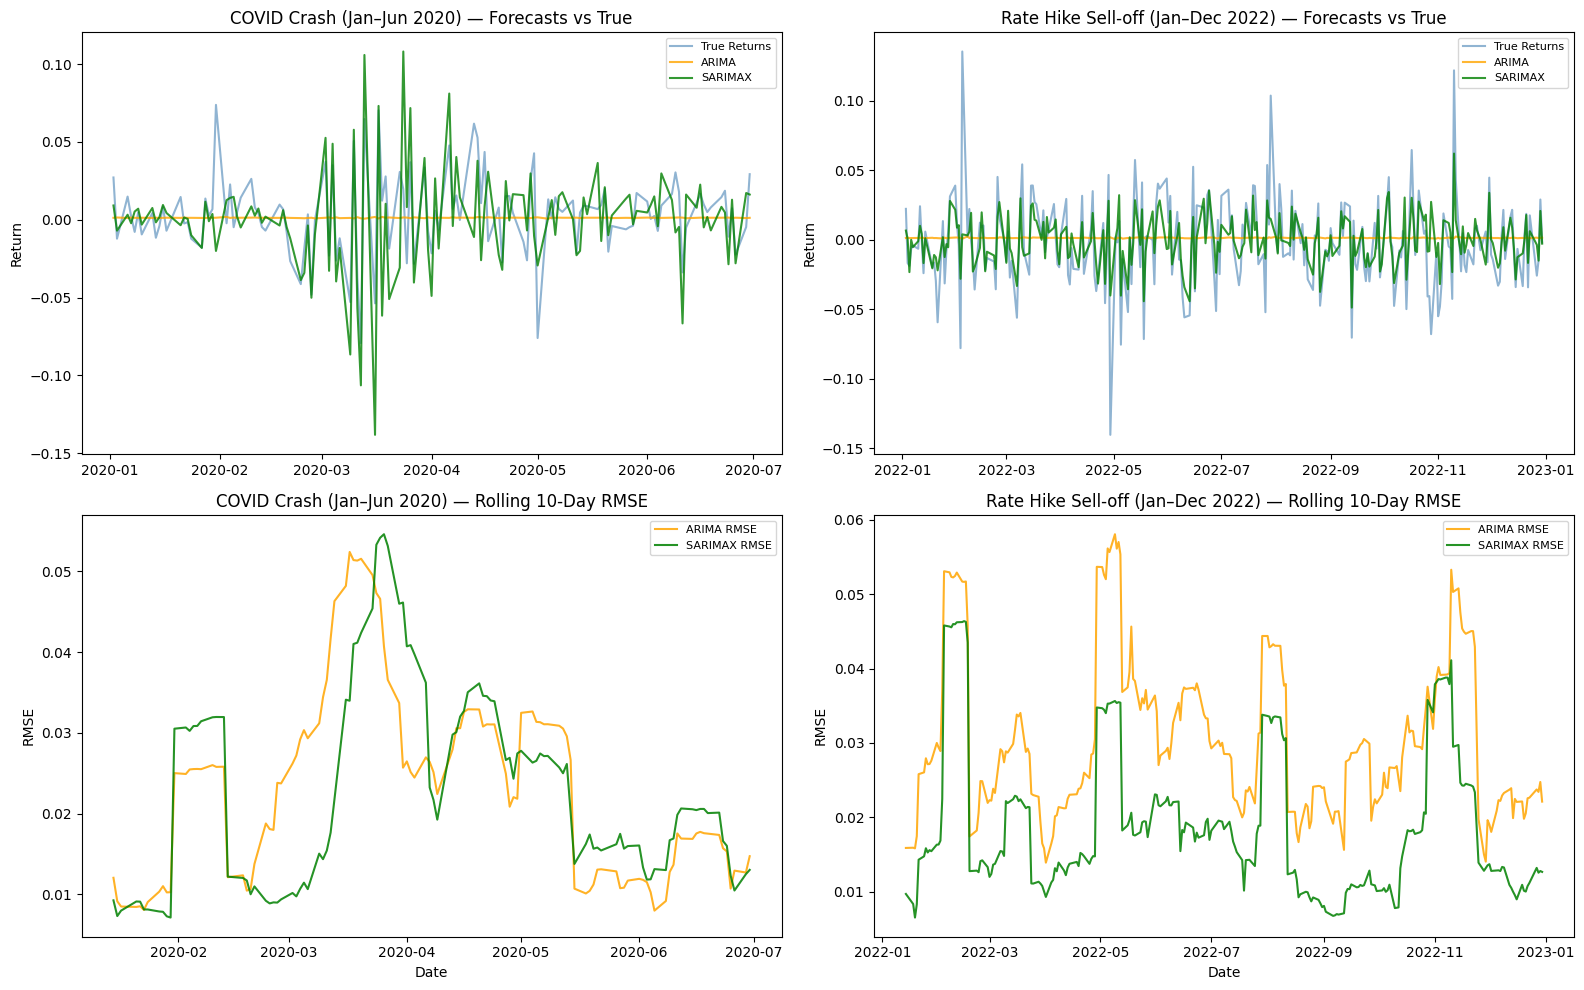

In [28]:
stress_periods = {
    "COVID Crash (Jan–Jun 2020)": ("2020-01-01", "2020-06-30"),
    "Rate Hike Sell-off (Jan–Dec 2022)": ("2022-01-01", "2022-12-31"),
}

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for col, (period_name, (start, end)) in enumerate(stress_periods.items()):
    y_sub   = y_test.loc[start:end]
    a_sub   = arima_forecast.loc[start:end]
    s_sub   = sarimax_forecast.loc[start:end]

    # Returns plot
    axes[0, col].plot(y_sub.index,  y_sub,  label="True Returns",    alpha=0.6, color="steelblue")
    axes[0, col].plot(a_sub.index,  a_sub,  label="ARIMA",           alpha=0.8, color="orange")
    axes[0, col].plot(s_sub.index,  s_sub,  label="SARIMAX",         alpha=0.8, color="green")
    axes[0, col].set_title(f"{period_name} — Forecasts vs True")
    axes[0, col].set_ylabel("Return")
    axes[0, col].legend(fontsize=8)

    # Rolling RMSE during stress
    rmse_a = ((y_sub - a_sub)**2).rolling(10).mean().apply(np.sqrt)
    rmse_s = ((y_sub - s_sub)**2).rolling(10).mean().apply(np.sqrt)
    axes[1, col].plot(rmse_a.index, rmse_a, label="ARIMA RMSE",   color="orange", alpha=0.85)
    axes[1, col].plot(rmse_s.index, rmse_s, label="SARIMAX RMSE", color="green",  alpha=0.85)
    axes[1, col].set_title(f"{period_name} — Rolling 10-Day RMSE")
    axes[1, col].set_ylabel("RMSE")
    axes[1, col].set_xlabel("Date")
    axes[1, col].legend(fontsize=8)

plt.tight_layout()
plt.show()

**Interpretation:**

- During the **COVID crash**, RMSE spikes sharply for both models as markets move violently in ways that the training data never captured at such speed and magnitude.
- During the **rate hike sell-off**, the decline is more gradual. SARIMAX benefits from the S&P 500 signal which consistently reflects the downward market trend, showing lower RMSE than ARIMA.
- These plots highlight that model performance is highly regime-dependent — a single aggregate metric hides important variation in forecast quality.

## 8. Price Reconstruction

We reconstruct the predicted price path by compounding the t+1 forecasted returns from the last known training price:

$$P_{t+1} = P_t \times (1 + \hat{r}_{t+1})$$

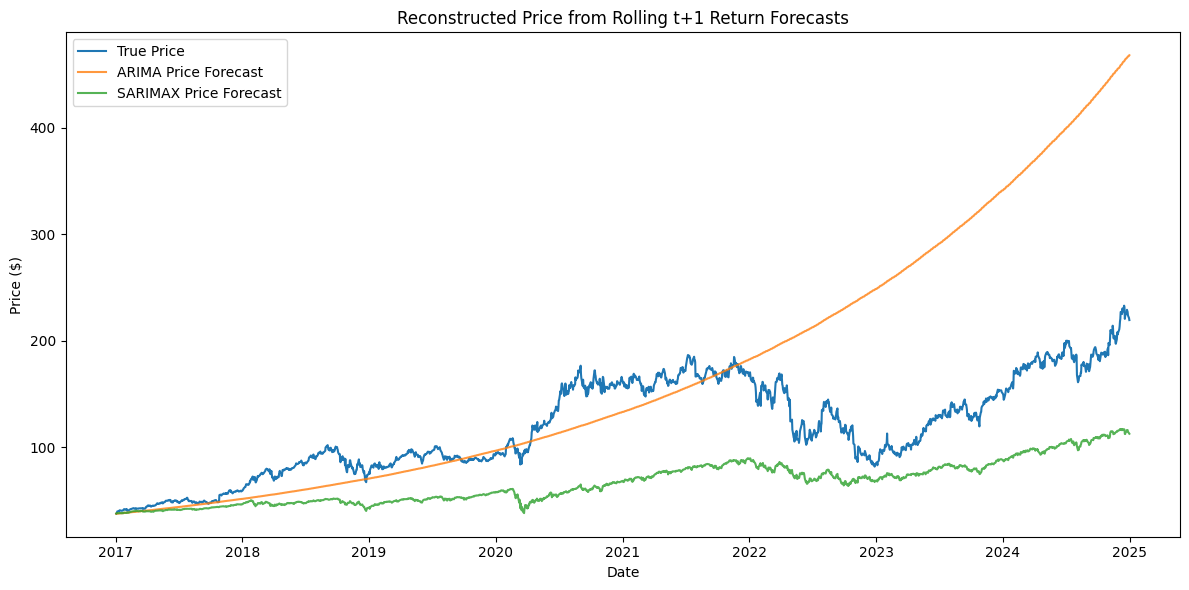

In [29]:
last_train_price = data.loc[data.index < split_date, "Price"].iloc[-1]

price_pred_arima, price_pred_sarimax = [], []
p_arima = p_sarimax = last_train_price

for r_arima, r_sarimax in zip(arima_forecast, sarimax_forecast):
    p_arima   = p_arima   * (1 + r_arima)
    p_sarimax = p_sarimax * (1 + r_sarimax)
    price_pred_arima.append(p_arima)
    price_pred_sarimax.append(p_sarimax)

price_pred_arima   = pd.Series(price_pred_arima,   index=y_test.index)
price_pred_sarimax = pd.Series(price_pred_sarimax, index=y_test.index)

plt.figure(figsize=(12, 6))
plt.plot(data.loc[data.index >= split_date, "Price"], label="True Price",            linewidth=1.5)
plt.plot(price_pred_arima,                            label="ARIMA Price Forecast",   alpha=0.8)
plt.plot(price_pred_sarimax,                          label="SARIMAX Price Forecast", alpha=0.8)
plt.legend()
plt.title("Reconstructed Price from Rolling t+1 Return Forecasts")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.tight_layout()
plt.show()

Even small daily biases in return forecasts accumulate exponentially over time, leading to large deviations from the true price path. This is a fundamental limitation of long-horizon price prediction with linear models.

## 6. Summary Table

We consolidate all evaluation results into a final comparison table.

In [30]:
print("=" * 65)
print("RETURN FORECAST — Full Test Set (2017–2024)")
print("=" * 65)
display(metrics_df)

print("\n" + "=" * 65)
print("VOLATILITY FORECAST — GARCH(1,1)")
print("=" * 65)
display(garch_metrics)

print("\n" + "=" * 65)
print("PERFORMANCE BY MARKET REGIME")
print("=" * 65)
display(regime_df)

RETURN FORECAST — Full Test Set (2017–2024)


,RMSE,MAE,MAPE (%),Directional Acc. (%)
Model,,,,
ARIMA,0.020813,0.014582,118.17,53.51
SARIMAX,0.015846,0.010726,182.13,73.30
Naïve (Random Walk),0.029799,0.020965,539.32,51.52



VOLATILITY FORECAST — GARCH(1,1)


,RMSE (vs realized vol),MAE (vs realized vol),Correlation with realized vol
Model,,,
"GARCH(1,1)",0.5931,0.5068,0.8554



PERFORMANCE BY MARKET REGIME


RMSE  Directional Acc. (%)
Regime                         Model                                  
Normal (2017–2019)             ARIMA    0.017299                 55.91
                               SARIMAX  0.012741                 73.97
                               Naïve    0.024618                 52.86
COVID Crash (2020)             ARIMA    0.024268                 55.16
                               SARIMAX  0.021710                 69.05
                               Naïve    0.036639                 50.40
Rate Hike Sell-off (2022–2023) ARIMA    0.026820                 50.20
                               SARIMAX  0.019020                 76.60
                               Naïve    0.038166                 50.00

## 10. Limitations & Future Directions

### Why do these models have limited performance?

**1. Linearity assumption**  
ARIMA and SARIMAX are linear models. Financial markets exhibit highly non-linear dynamics — the relationship between past returns and future returns is not constant and depends on market regime, sentiment, and macro conditions.

**2. Single exogenous variable**  
SARIMAX only uses S&P 500 returns as context. Many other factors drive Amazon's stock: earnings releases, interest rates, sector rotation, analyst upgrades, news sentiment, etc.

**3. Stationarity assumption**  
ARIMA assumes stable statistical properties over time. The structural breaks visible in the data (2008, COVID, 2022) violate this assumption and cause the model to underperform during regime changes.

**4. No memory of long-term context**  
The models only capture short-term autocorrelation (p=1, q=1). They cannot learn long-term patterns or multi-step dependencies.

### What would improve performance?

| Approach | What it adds |
|----------|--------------|
| **XGBoost / Random Forest** | Non-linear relationships, many features, robustness |
| **LSTM / Transformer** | Long-term temporal dependencies, sequence modeling |
| **Regime-switching models** | Explicit modeling of different market states |
| **Sentiment features** | News, earnings, analyst ratings as additional signals |
| **Macro features** | Interest rates, VIX, sector ETFs as context |

## Conclusion

This evaluation notebook provides a complete picture of the models' out-of-sample performance:

- **SARIMAX consistently outperforms ARIMA** and the naïve random walk benchmark on all return metrics (RMSE, MAE, Directional Accuracy), confirming that incorporating broad market movements adds predictive value.

- **Residuals analysis** shows that both models have near-zero mean bias but exhibit heavy tails and heteroskedasticity — errors are larger and more clustered during volatile periods.

- **Rolling RMSE** reveals that performance degrades significantly during crisis periods (COVID, 2022) and recovers during calmer regimes, confirming that model accuracy is highly regime-dependent.

- **Stress tests** confirm that the COVID crash is the most challenging period for all models, while SARIMAX maintains a relative advantage during the more gradual 2022 sell-off.

- **GARCH successfully forecasts volatility**, confirming the well-known result that volatility is more predictable than returns.

Overall, these statistical models establish a rigorous baseline. Their limitations — linearity, single exogenous variable, sensitivity to regime changes — clearly motivate the use of more flexible machine learning models as a natural next step.